## This is the T01 Tech Challenge for CapTech

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import collections
from __future__ import division
from collections import Counter

%pylab inline
matplotlib.rcParams['figure.figsize'] = (12,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#creating Pandas dataframe from CSV file
loans_df = pd.read_csv('loanStats.csv')

C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Notebook Functions

In [3]:
def sort_for_graph(uodict,sort_key,order):
    if sort_key == "key":
        key_num=0
    elif sort_key == "value":
        key_num=1
        
    if order == "desc":
        orderBool = True
    elif order == "asc":
        orderBool = False
    odict = sorted(uodict.items(), key=operator.itemgetter(key_num),reverse=orderBool)
    keys = zip(*odict)[0]
    values = zip(*odict)[1]
    
    return keys,values

In [4]:
def convert_date(x):
    if type(x) is str:
        return strftime("%m-%d-%Y", strptime(x, "%Y%m%dT%H%M%S"))
    else:
        return "00-00-0000"

### Analyzing the columns and first set of rows within the dataset

In [ ]:
print loans_df.ix[:,0:6].head(5)

In [ ]:
print loans_df.ix[:,6:13].head(5)

In [ ]:
print loans_df.ix[:,13:19].head(5)

In [ ]:
print loans_df.ix[:,19:26].head(5)

In [ ]:
print loans_df.ix[:,26:33].head(5)

In [ ]:
print loans_df.ix[:,33:40].head(5)

In [ ]:
print loans_df.ix[:,41:46].head(5)

In [ ]:
print loans_df.ix[:,47:53].head(5)

In [ ]:
print loans_df.ix[:,54:60].head(5)

### Data Cleaning

#### Columns

In analyzing the dataset of loans provided by Lending Club, several columns were identified that needed cleaning:
1.  There are inconsistencies between the Loan Purpose and the Loan Title.  There may need to be additional Loan Purposes added as someone listed the Loan Purpose as "Car", but the Title listed "Bike".
2.  Employer title column has blanks as well as many typos.  We need to find out if the blanks mean unemployed and there should be some employer name verification, so that we can analyze the data by this field if necessary.
3.  The zip code column has some encryption on it in the database.  We won't be able to analyze the data by location without this information.  We can see if we can find a way to store it in an un-encrypted format in order to analyze the data that way.
4.  The loan status column seems to have duplicate statuses. One that is normal and one that states that the borrower does not meet the credit policy.  The "does not meet credit policy" should be in it's own column and be combined later in analysis if needed.

#### Rows

Specific rows seem to have inconsistencies.  The following identified are:
1.  IDs 1077501, 1077175, and 1071795 have no employer title listed where the employer length is given as something greater than zero.  These are rows before 9/23/2013 where it looks like this was not enforced, but it is even seen on ID 9776036 which is after that date.  We will need to check with the appropriate stakeholders and determine if there is a meaning behind that.  If it is something such as self-employment, then it would be good to indicate something like that.
2.  There are blank rows in the "inq_last_6mths" column.  It looks as though this correlates with people who have zero open credit accounts.  We can probably assume that these are zeroes, but will want to confirm with the stakeholders.
3.  There are blank rows in the "collections_12_mths_ex_med" column.  These may correlate with the "inq_last_6mths" blanks, but will need to confirm that with the stakeholders too.

#### Cleaning Up Date Columns

In [14]:
from time import gmtime, strftime, strptime

In [15]:
loan_dates_df = loans_df.loc[:,['issue_d','earliest_cr_line','next_pymnt_d','last_credit_pull_d','final_d','last_pymnt_d']]
for i in range(len(loan_dates_df.keys())):
    loan_dates_df.rename(columns={loan_dates_df.keys()[i]: loan_dates_df.keys()[i]+'_fmt'}, inplace=True)

In [16]:
loan_dates_df = loan_dates_df.applymap(convert_date)
loans_df = pd.merge(loans_df, loan_dates_df, left_index=True, right_index=True) #merge into existing table

### Data Understanding

#### Numerical Variables

Here are a list of the major numerical variables captured for Lending Club:

Loan amount, installment, employer length, debt-to-income, inquiries over the last 6 months, open accounts, total accounts, and revolving balance. 

In [17]:
#create a table with only numerical variables
numerical_df = loans_df.loc[:, ['loan_amnt', 'installment', 'emp_length_num','dti','inq_last_6mths' \
                                ,'open_acc','total_acc','revol_bal']]

In [18]:
#standardize the tables with numerical variables
numerical_df_std = (numerical_df - numerical_df.mean()) / (numerical_df.max() \
                                                                         - numerical_df.min())

Lets take a very high level look at the distributions of these variables.

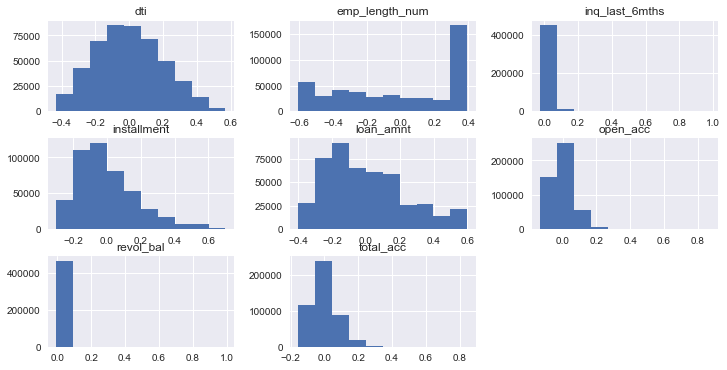

In [19]:
numerical_df_std.hist();

##### 1. Debt-To-Income Ratio (DTI)

This variable measures the percentage of debt owned by the member compared to the income they receive.  Typically this is done on a monthly basis in order to more easily understand the monthly disposable income that a person would have remaining when they apply for a loan.  Lenders would want to see a generally low number here representing available funds to pay off a new loan.

In [20]:
numerical_df['dti'].describe()

count    466287.000000
mean         17.218747
std           7.851106
min           0.000000
25%          11.360000
50%          16.870000
75%          22.780000
max          39.990000
Name: dti, dtype: float64

Here we can see that the data type of DTI is a floating type.

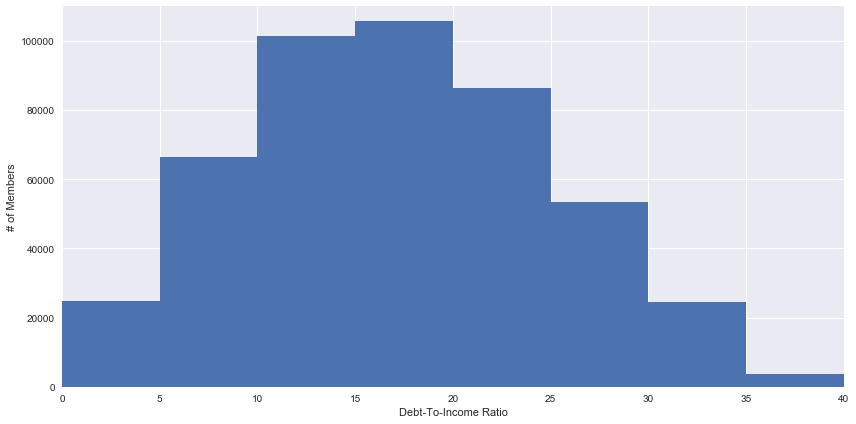

In [21]:
plt.hist(numerical_df['dti'],8)
plt.axis([0, round(numerical_df['dti'].max()+(numerical_df['dti'].max()*.01)), 0, 110000])
plt.xlabel('Debt-To-Income Ratio')
plt.ylabel('# of Members')
plt.tight_layout()
plt.show()

When viewing the data on a scale from min to max, the distribution of the DTI for members who are approved for loans looks like a normally distributed range of values.

However, if you take into account a person could have a DTI ratio of 0 to 100, the distribution becomes negatively skewed.

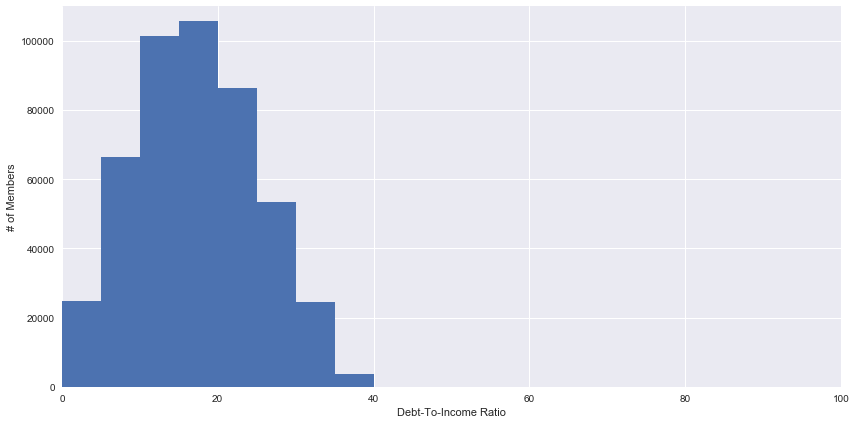

In [22]:
plt.hist(numerical_df['dti'],8)
plt.axis([0, 100, 0, 110000])
plt.xlabel('Debt-To-Income Ratio')
plt.ylabel('# of Members')
plt.tight_layout()
plt.show()

In general, it looks like Lending Club only accepts people with a DTI ratio of 35 or less.  It would be interesting to examine what other set of criteria allowed people with over a 35 DTI ratio be approved for a loan.

##### 2. Total Accounts

Total accounts is the number of credit lines currently on the borrower's credit file.  Total accounts only paint a portion of the picture as these aren't listed as currently open or the status of whether they were completely paid off or not.  In general though, it's probably best to see some credit lines opened, but not too many.

In [23]:
numerical_df['total_acc'].describe()

count    466258.000000
mean         25.064432
std          11.600136
min           1.000000
25%          17.000000
50%          23.000000
75%          32.000000
max         156.000000
Name: total_acc, dtype: float64

Here we can see that the data type of Total Accounts is a floating type.

C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


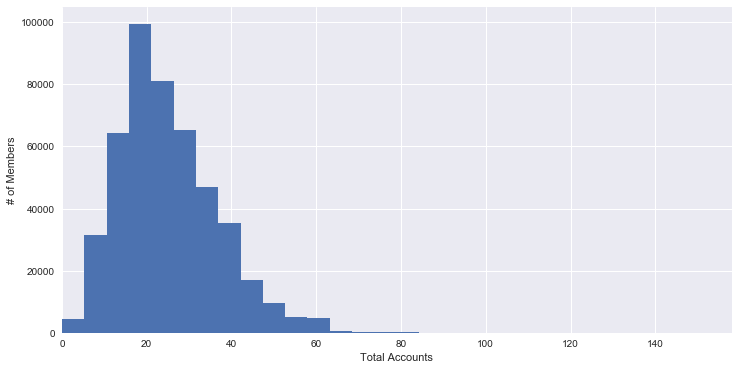

In [24]:
#numerical_df['total_acc'].hist()
plt.hist(numerical_df['total_acc'],30,(0,round(numerical_df['total_acc'].max()+(numerical_df['total_acc'].max()*.01))))
plt.axis([0, round(numerical_df['total_acc'].max()+(numerical_df['total_acc'].max()*.01)), 0, 105000])
plt.xlabel('Total Accounts')
plt.ylabel('# of Members')
plt.show()

The distribution for number of total accounts of approved borrowers with a loan at Lending Club is negatively skewed.  This was expected as you would like people with a lower amount of accounts.

There are a couple members who are so far off of the distrubution, that you aren't even able to see a bar accounting for their existence.

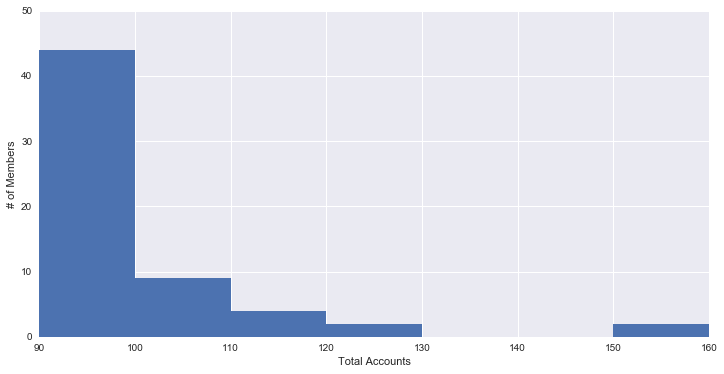

In [25]:
#numerical_df['total_acc'].hist()
plt.hist(numerical_df['total_acc'],7,(90,160))
plt.axis([90, 160, 0, 50])
plt.xlabel('Total Accounts')
plt.ylabel('# of Members')
plt.show()

Zooming in a little closer on those individuals, we can see there are about 20 people who have over 100 accounts open on their credit file.  Maybe these people are older and they have built up a history their entire life, but it would be interesting to see the makeup of these individuals.

##### 3. Open Accounts

After asking a question about the borrowers with a lot of total accounts, it would be interesting to see the distribution of people with open accounts on their credit file.  Open accounts is the number of credit lines currently open the borrower's credit file.  In general, a lender would like to see a borrower with some accounts open to prove that he or she would have the ability to regularly pay on those accounts, but you wouldn't want to see too many which would show that the borrower has a lot of institutions that he or she regularly has to pay.

In [26]:
numerical_df['open_acc'].describe()

count    466258.000000
mean         11.187060
std           4.987517
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          84.000000
Name: open_acc, dtype: float64

Here we can see that the data type of Open Accounts is a floating type.

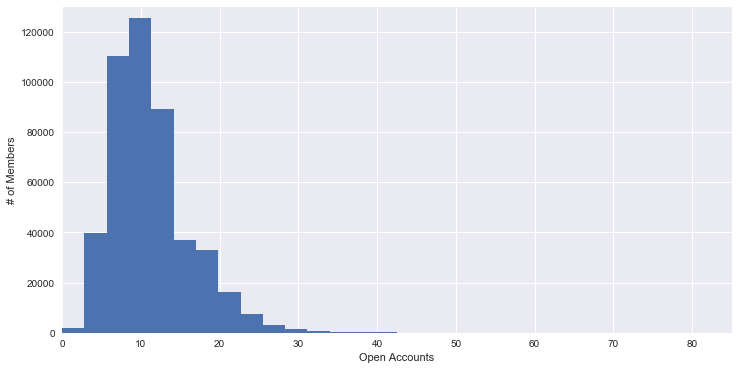

In [27]:
#numerical_df['total_acc'].hist()
plt.hist(numerical_df['open_acc'],30,(0,round(numerical_df['open_acc'].max()+(numerical_df['open_acc'].max()*.01))))
plt.axis([0, round(numerical_df['open_acc'].max()+(numerical_df['open_acc'].max()*.01)), 0, 130000])
plt.xlabel('Open Accounts')
plt.ylabel('# of Members')
plt.show()

The distribution for number of open accounts of approved borrowers with a loan at Lending Club is negatively skewed.  This was expected as you would like people with a lower amount of open borrowing accounts.

Again, we see there are a couple members who are so far off of the distrubution, that you aren't even able to see a bar accounting for their existence.

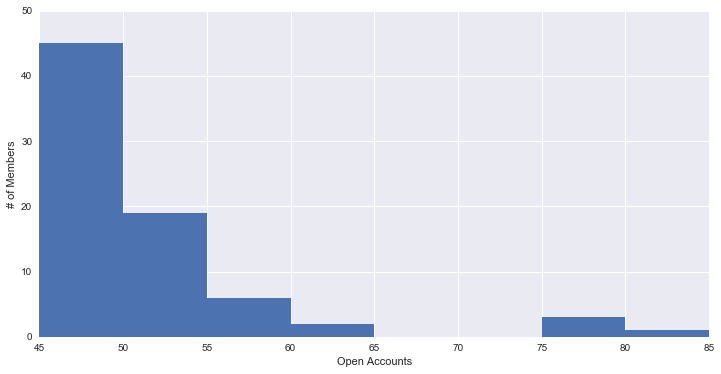

In [28]:
#numerical_df['total_acc'].hist()
plt.hist(numerical_df['open_acc'],8,(45,round(numerical_df['open_acc'].max()+(numerical_df['open_acc'].max()*.01))))
plt.axis([45, round(numerical_df['open_acc'].max()+(numerical_df['open_acc'].max()*.01)), 0, 50])
plt.xlabel('Open Accounts')
plt.ylabel('# of Members')
plt.show()

There are people with over 75 open credit accounts that were approved for loans!  That seems like a huge risk.  I would love to look into that.

##### 4. Employer Length

Employer length is simple a measurement of how long a borrower has currently been with their current employer in terms of years.  In general, a lender is looking for someone with stability, so the higher number of years would be better.

In [29]:
numerical_df['emp_length_num'].describe()

count    466287.000000
mean          6.678243
std           3.829742
min           0.000000
25%           3.000000
50%           7.000000
75%          11.000000
max          11.000000
Name: emp_length_num, dtype: float64

Here we can see that the data type of Employer Length is a floating type.

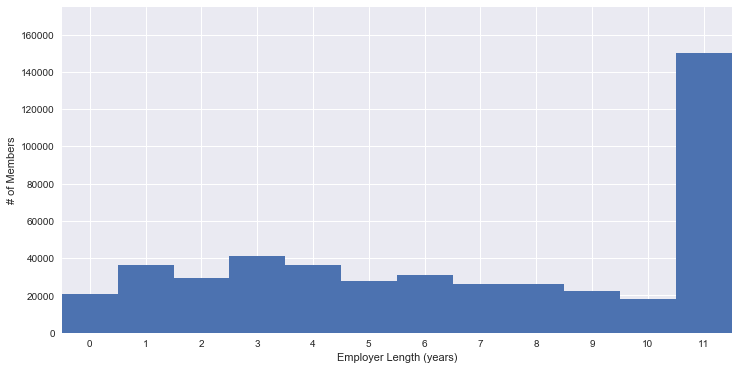

In [30]:
plt.hist(numerical_df['emp_length_num'],np.arange(13)-0.5,(-.5,11.5))
plt.axis([-.5, 11.5, 0, 175000])
plt.xlabel('Employer Length (years)')
plt.xticks(range(12), range(12))
plt.ylabel('# of Members')
plt.show()

The distribution for Employer Length is fairly uniform.  There is a large number for 11, but that is because it includes anything above 10.  If we were to expand that number, it would most likely continue to flatten out to a certain extent.

##### 5. Loan Amount

Loan amount is the dollar figure for the amount of money given to the borrower.  It does not include what the interest will amount to, but just the principal that will need to be paid back.

In [31]:
numerical_df['loan_amnt'].describe()

count    466287.000000
mean      14317.280505
std        8286.497984
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Here we can see that the data type of Loan Amount is a floating type.

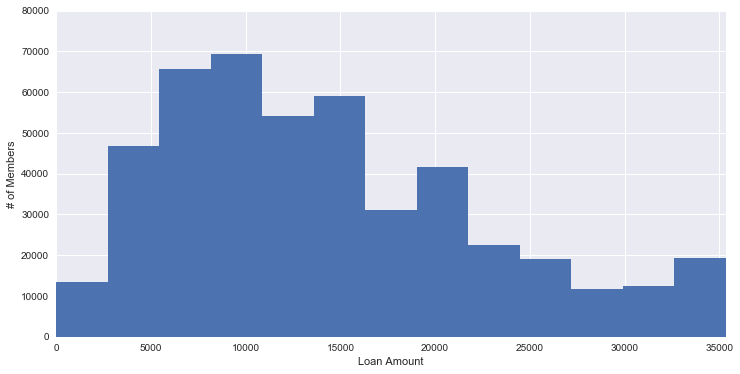

In [32]:
plt.hist(numerical_df['loan_amnt'],13,(0,round(numerical_df['loan_amnt'].max()+(numerical_df['loan_amnt'].max()*.01))))
plt.axis([0,round(numerical_df['loan_amnt'].max()+(numerical_df['loan_amnt'].max()*.01)), 0, 80000])
plt.xlabel('Loan Amount')
plt.ylabel('# of Members')
plt.show()

This distribution for loan amount is generally negatively skewed.  There is an uptick of loan amounts around $20,000.  It would be interesting to see what would cause that.  Maybe most of the loans in that area are for a car.

#### Categorical Variables

Here are a list of the major categorical variables captured for Lending Club:

Addr state, grade, subgrade, home ownership, purpose, and loan status

In [33]:
#create a table with only numerical variables
categorical_df = loans_df.loc[:, ['addr_state', 'grade', 'sub_grade','home_ownership','purpose' \
                                ,'loan_status','loan_amnt','avg_cur_bal']]

##### State

State refers to the residency address of the borrower.  This is captured in a String format of the 2 letter abbreviation of the state.

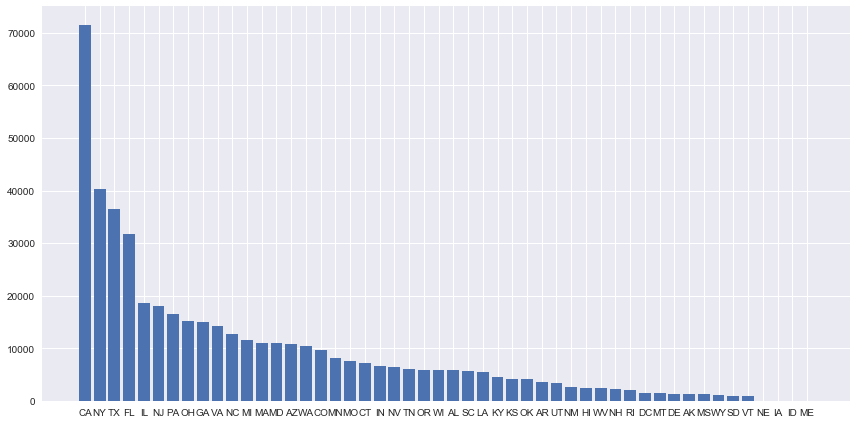

In [56]:
state_freq = Counter(categorical_df['addr_state'])

#return sorted order of grades and counts
states, state_counts = sort_for_graph(state_freq,"value","desc")

plt.bar(range(len(state_freq)),state_counts)
plt.xticks(range(len(state_freq)),states)
plt.tight_layout()
plt.show()

The top 3 states look to be California, New York, and Texas.  That isn't very surprising due to their populations overall and population of people with higher incomes.  It would be interesting to take a look at the top 5 and bottom 5 and standardize the data against the populations and incomes of those states.

##### Purpose

Purpose looks to be a dropdown list of items that borrowers select from when applying for their loan.  This is good for the fact that it categorizes our loans much easier than the free form text box that the column 'Title' provides.

The Purpose is stored as a string.

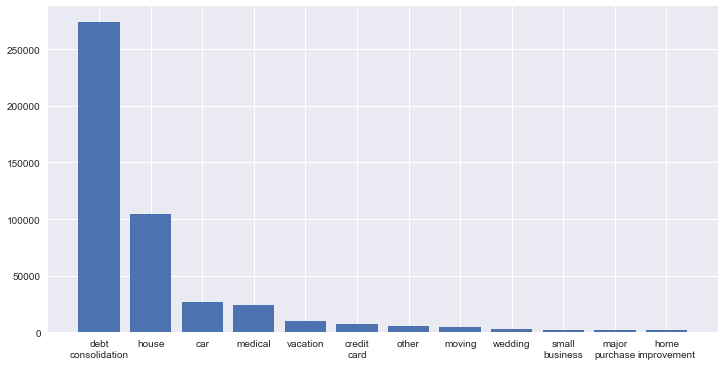

In [35]:
purpose_freq = Counter(categorical_df['purpose'])

#return sorted order of purposes and counts
purposes, purpose_counts = sort_for_graph(purpose_freq,"value","desc")

#add line breaks in keys so that we can easily see them on the graph
purposes = list(purposes)
for x,str in enumerate(purpose_freq.keys()):
    purposes[x] = str.replace('_','\n')

#print graph
plt.bar(range(len(purpose_freq)),purpose_counts)
plt.xticks(range(len(purpose_freq)),purposes)
plt.show()

As expected, most people get a personal loan to try and lower the interest rate of existing debt as shown by the debt consolidation purpose.  With a home loan, that would traditionally be a very big amount and for a 30 year term.  The terms on the loans for Lending Club are only 5 years.  These loans may be for a down payment, but it would be interesting to dive into that.

##### Home Ownership

Home Ownership looks to be a dropdown list of items that borrowers select from when applying for their loan.  It is categorized into fully owning, renting, owning with a mortgage, and other.

Home Ownership is stored as a string.

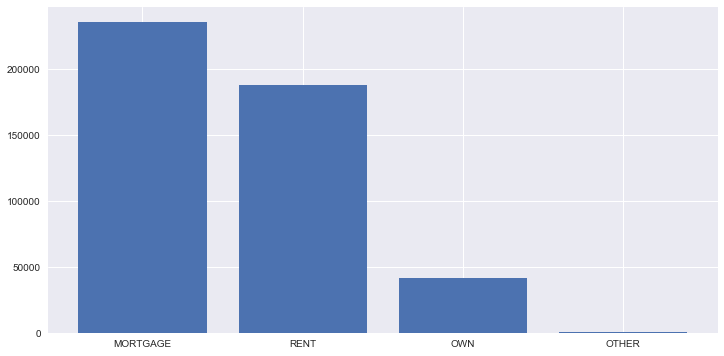

In [36]:
home_own_freq = Counter(categorical_df['home_ownership'])
   
#return sorted order of home ownership and counts
home_owns, home_own_counts = sort_for_graph(home_own_freq,"value","desc")

#print graph
plt.bar(range(len(home_own_freq)),home_own_counts)
plt.xticks(range(len(home_own_freq)),home_owns)
plt.show()

Not much too exciting here by itself.  It would be interesting to cross-section this information with the loan purpose.  We may gain some information about whether those that currently rent are the ones looking for houses or that those who own a house are now starting their own business.

#### 4.	What is the average loan amount, average DTI (debt-to-income ratio), and average PTI (loan payment-to-income ratio)?

In [37]:
print '${:,.2f}'.format(loans_df['loan_amnt'].mean())

$14,317.28


In [38]:
print loans_df['dti'].mean()

17.2187468448


In [39]:
PTI = (loans_df['installment']/(loans_df['annual_inc']/12)*100)
print PTI.mean()

8.01044361602


In [40]:
loan_orig_month = ['month']

for id, date in enumerate(loans_df['issue_d_fmt']):
    loan_orig_month.append(datetime.datetime.strptime(date, "%m-%d-%Y").month)

loan_orig_month.remove('month')

#### 5.	What is the most common month for issuing new loans?

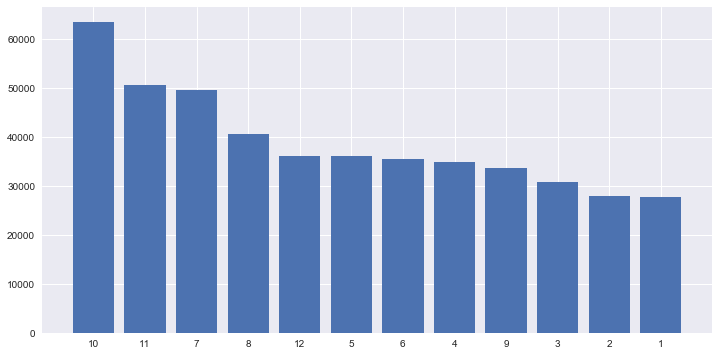

In [41]:
month_freq = Counter(loan_orig_month)

#return sorted order of purposes and counts
months, month_counts = sort_for_graph(month_freq,"value","desc")

#print graph
plt.bar(range(len(month_freq)),month_counts)
plt.xticks(range(len(month_freq)),months)
plt.show()

The most common month for new loans is October.

#### 6.	What is the most common day that loans were fully paid off?

In [42]:
loan_paid_day = ['day']

for id, date in enumerate(loans_df['final_d_fmt']):
    if date <> '00-00-0000':
        loan_paid_day.append(datetime.datetime.strptime(date, "%m-%d-%Y").day)

loan_paid_day.remove('day')

In [43]:
day_freq = Counter(loan_paid_day)
print day_freq

Counter({1: 466287})


All payments are made on the first of the month so final payments would happen on the first as well.

#### 7.	Plot a bar graph for grades and subgrades. What does this tell you about the Lending Club’s current portfolio of loans?

In [44]:
grades_subgrades_df = loans_df.loc[:, ['grade','sub_grade']]

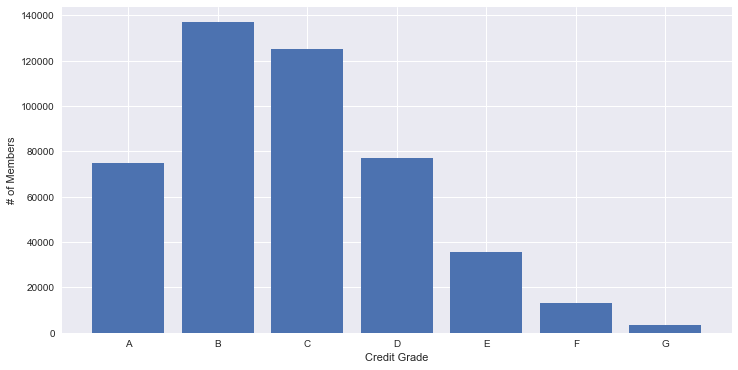

In [45]:
#create counter of grades
grade_freq = Counter(grades_subgrades_df['grade'])

#return sorted order of grades and counts
grades, grade_counts = sort_for_graph(grade_freq,"key","asc")

#graph out grades and counts
plt.bar(range(len(grade_freq)),grade_counts)
plt.xlabel('Credit Grade')
plt.ylabel('# of Members')
plt.xticks(range(len(grade_freq)), grades)
plt.show()

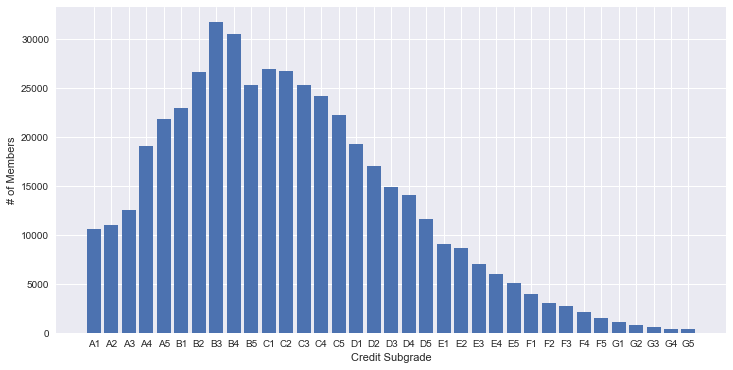

In [46]:
subgrade_freq = Counter(grades_subgrades_df['sub_grade'])

#return sorted order of grades and counts
grades, grade_counts = sort_for_graph(subgrade_freq,"key","asc")

plt.bar(range(len(subgrade_freq)),grade_counts)
plt.xticks(range(len(subgrade_freq)),grades)
plt.xlabel('Credit Subgrade')
plt.ylabel('# of Members')
plt.show()

#### 8.	Check out the “status” variable. What do each of the categories mean? Which category is the largest?

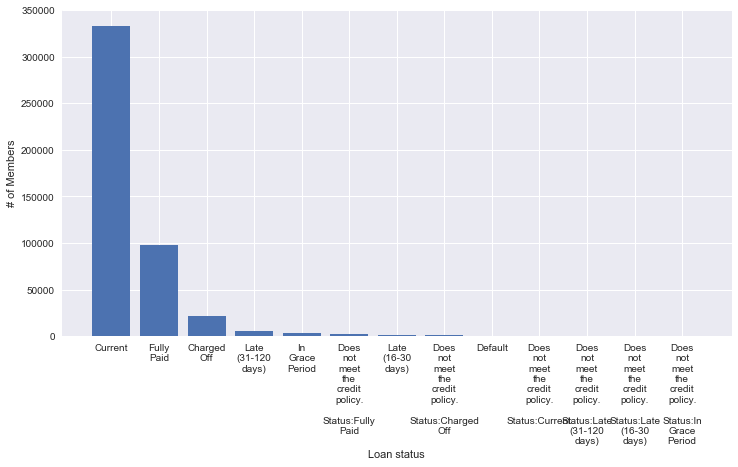

In [47]:
#create counter of statuss
status_freq = Counter(categorical_df['loan_status'])

#return sorted order of statuss and counts
statuses, status_counts = sort_for_graph(status_freq,"value","desc")

#add line breaks in keys so that we can easily see them on the graph
statuses = list(statuses)
for x,str in enumerate(statuses):
    statuses[x] = str.replace(' ','\n')

#graph out statuses and counts
plt.bar(range(len(status_freq)),status_counts)
plt.xlabel('Loan status')
plt.ylabel('# of Members')
plt.xticks(range(len(status_freq)), statuses)
plt.show()

This graph shows good news for Lending Club.  Over 75% of the loans in existence are currently open and in a "Current" status which should mean they're receiving payments when they expect to.  Also of note, is that there are very few not in good standing.  But of those not in good standing, the biggest number comes from 31-120 days late so those people might start to fall into the Default bucket.

Loan status is definitely important to the analysis of Lending Club as it gives a high level picture to executives as to where and when to expect revenue and report on that.

#### 9. Based on your analysis of the status categories in the previous question, create a flag variable that indicates whether a loan is bad or not.

In [48]:
bad_status = ['Charged Off', 'Late (31-120 days)','Does not meet the credit policy.  Status:Charged Off',\
              'Default','Does not meet the credit policy.  Status:Late (31-120 days)']
bad_status_col = ['bad_status_col']

for status in loans_df['loan_status']:
    bad_status_col.append(status in bad_status) 

bad_status_col.remove('bad_status_col')

bad_status_df = pd.DataFrame(data={'bad_loan':bad_status_col})
    
loans_df = pd.merge(loans_df, bad_status_df, left_index=True, right_index=True) #merge into existing table

In [49]:
bad_loans_df = loans_df[loans_df.bad_loan == True]
good_loans_df = loans_df[loans_df.bad_loan == False]

##### Comparing the DTI of Good and Bad Loans

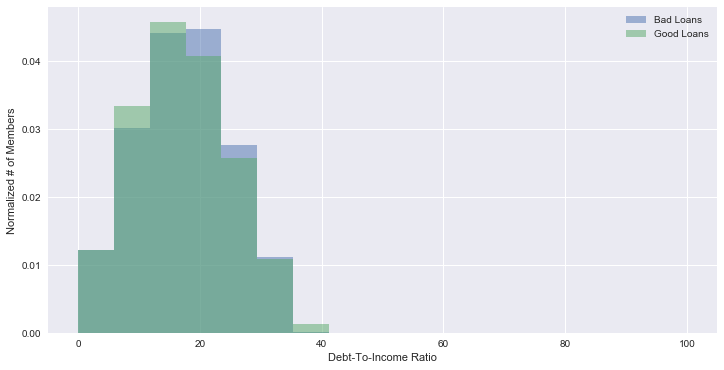

In [50]:
plt.hist(bad_loans_df.dti,17,(0,100),alpha=0.5, label='Bad Loans', normed=True)
plt.hist(good_loans_df.dti,17,(0,100),alpha=0.5, label='Good Loans', normed=True)
#plt.axis([0, 100, 0, 100])
plt.xlabel('Debt-To-Income Ratio')
plt.ylabel('Normalized # of Members')
plt.legend(loc='upper right')
plt.show()

The distributions looks fairly simliar here.  The mean of the Bad Loans looks to be a tad higher, but nothing that we could use to determine where significant risk becomes a factor on DTI ratio.

##### Comparing the Open Accounts of Borrowers with Good and Bad Loans

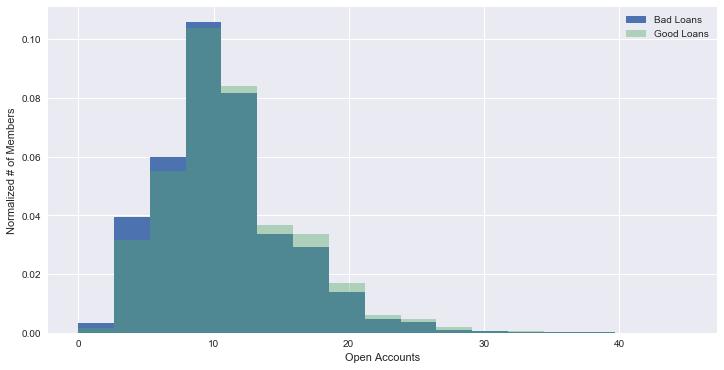

In [51]:
plt.hist(bad_loans_df.open_acc,17,(0,45),alpha=1, label='Bad Loans', normed=True)
plt.hist(good_loans_df.open_acc,17,(0,45),alpha=0.4, label='Good Loans', normed=True)
#plt.axis([0, 45, 0, 125000])
plt.xlabel('Open Accounts')
plt.ylabel('Normalized # of Members')
plt.legend(loc='upper right')
plt.show()

The distributions looks fairly simliar here.  There is almost nothing that looks distinguishable between the two.

##### Comparing the Credit Grades of Borrowers with Good and Bad Loans

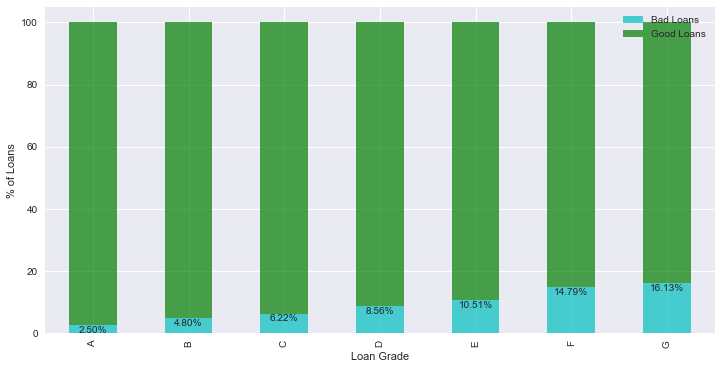

In [58]:
bad_loan_grade_freq = Counter(bad_loans_df.grade)
good_loan_grade_freq = Counter(good_loans_df.grade)

#return sorted order of grades and counts
bad_grades, bad_grade_counts = sort_for_graph(bad_loan_grade_freq,"key","asc")
good_grades, good_grade_counts = sort_for_graph(good_loan_grade_freq,"key","asc")

bad_grade_pct = pd.Series.from_array([bad_grade_counts[i]/(bad_grade_counts[i]+good_grade_counts[i]) \
                 * 100 for i in range(len(bad_grade_counts))])
good_grade_pct = pd.Series.from_array([good_grade_counts[i]/(bad_grade_counts[i]+good_grade_counts[i]) \
                  * 100 for i in range(len(good_grade_counts))])

ax1 = bad_grade_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax1.set_xticklabels(bad_grades)
ax2 = good_grade_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=bad_grade_pct, color='g')
ax2.set_xlabel("Loan Grade")
ax2.set_ylabel("% of Loans")
ax2.set_xticklabels(bad_grades)

rects = ax1.patches
labels = ["{0:.2f}%".format(bad_grade_pct[i]) for i in xrange(len(bad_grade_pct))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 3, label, ha='center', va='bottom')
               
plt.legend(loc='upper right')
plt.show()

If we look at this distribution as a percentage of good and bad loans respectively, then we can see a slightly higher number of loans that have a grade of D or lower in the bad loans.  This looks to be a pretty big indicator of what determines a good loan versus a bad loan.

##### Comparing the Loan Purpose of Borrowers with Good and Bad Loans

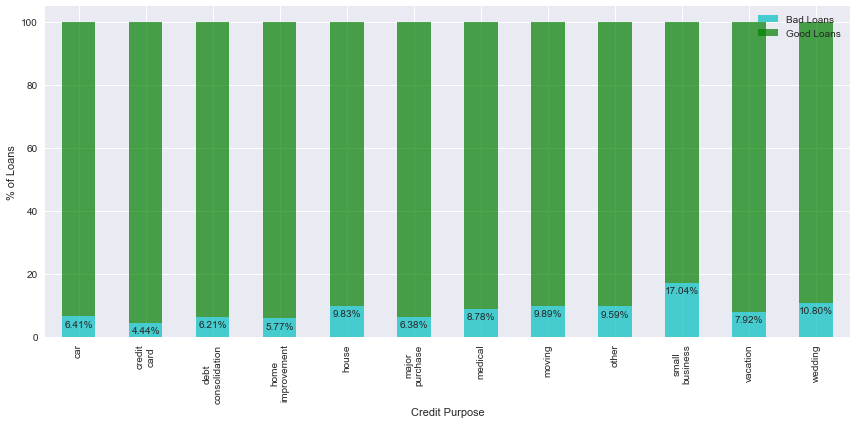

In [53]:
bad_loan_purpose_freq = Counter(bad_loans_df.purpose)
good_loan_purpose_freq = Counter(good_loans_df.purpose)

#return sorted order of purposes and counts
bad_purposes, bad_purpose_counts = sort_for_graph(bad_loan_purpose_freq,"key","asc")
good_purposes, good_purpose_counts = sort_for_graph(good_loan_purpose_freq,"key","asc")

bad_purpose_pct = pd.Series.from_array([bad_purpose_counts[i]/(bad_purpose_counts[i]+good_purpose_counts[i]) \
                   * 100 for i in range(len(bad_purpose_counts))])
good_purpose_pct = pd.Series.from_array([good_purpose_counts[i]/(bad_purpose_counts[i]+good_purpose_counts[i]) \
                    * 100 for i in range(len(good_purpose_counts))])

#add line breaks in keys so that we can easily see them on the graph
bad_purposes = list(bad_purposes)
for x,str in enumerate(bad_purposes):
    bad_purposes[x] = str.replace('_','\n')
    
ax1 = bad_purpose_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax2 = good_purpose_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=bad_purpose_pct, color='g')
ax2.set_xlabel("Credit Purpose")
ax2.set_ylabel("% of Loans")
ax2.set_xticklabels(bad_purposes)

rects = ax1.patches
labels = ["{0:.2f}%".format(bad_purpose_pct[i]) for i in xrange(len(bad_purpose_pct))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 4, label, ha='center', va='bottom')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [54]:
print "{0:.2f}%".format(sum(bad_purpose_counts) / (sum(bad_purpose_counts)+sum(good_purpose_counts)) * 100)

6.23%


It looks like those who apply for loans for the purpose of Small Businesses have a much higher Bad Loan Percentage than the average loan.  We can look into determining whether Small Business loans by default will come with much higher risk.

##### Comparing the Home Ownership Status of Borrowers with Good and Bad Loans

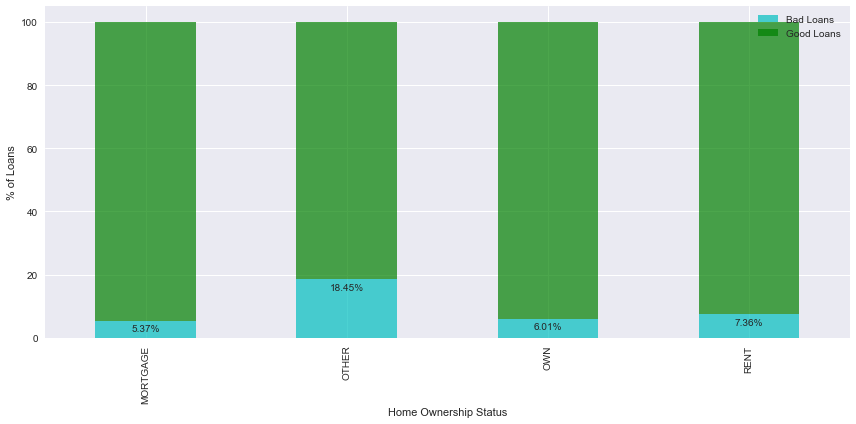

In [55]:
bad_loan_ho_freq = Counter(bad_loans_df.home_ownership)
good_loan_ho_freq = Counter(good_loans_df.home_ownership)

#return sorted order of hos and counts
bad_ho, bad_ho_counts = sort_for_graph(bad_loan_ho_freq,"key","asc")
good_ho, good_ho_counts = sort_for_graph(good_loan_ho_freq,"key","asc")

bad_ho_pct = pd.Series.from_array([bad_ho_counts[i]/(bad_ho_counts[i]+good_ho_counts[i]) \
                   * 100 for i in range(len(bad_ho_counts))])
good_ho_pct = pd.Series.from_array([good_ho_counts[i]/(bad_ho_counts[i]+good_ho_counts[i]) \
                    * 100 for i in range(len(good_ho_counts))])
    
ax1 = bad_ho_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax2 = good_ho_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=bad_ho_pct, color='g')
ax2.set_xlabel("Home Ownership Status")
ax2.set_ylabel("% of Loans")
ax2.set_xticklabels(bad_ho)

rects = ax1.patches
labels = ["{0:.2f}%".format(bad_ho_pct[i]) for i in xrange(len(bad_ho_pct))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 4, label, ha='center', va='bottom')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

We evaluated the number of borrowers by Home Ownership status earlier and there weren't many people that fell into the Other category.  However, nearly 1 in 5 of these borrowers have a bad loan.  We may need to look further into what different types of situations this could encapsulate and if there any any specific risk we can mitigate here.

**Of the 5 variables you chose, could any of these cause loans to go bad?**

I'm not sure that we can immediately say that "Other" Home Ownership or "Small Business" loans immediately make a loan go bad at this point, but we can probably dig further into these types of loans to see what combination of criteria typically leads to a bad loan so that we can try to mitigate that risk as much as possible in the future.

### Conclusions

The Lending Club looks to have a pretty good understanding of how to minimize risk on the loans that they approve for their investors.  

If we define a bad loan as one that has been Charged Off, Defaulted, or is over 30 days late, then only 6.2% of their loans are categorized as loans in a bad position.  They have utilized the major factors such as previous credit history and certified income to get it down to that level.

However, there are other such factors that we could dive further down into to try and lower that number further.  We saw that loans for Small Business and borrowers with an undefined home ownership status tend to have a higher risk.  There are probably specific factors hiding in those numbers that we can isolate and use in a loan application to determine whether Lending Club wants to assume those risks.

We could also continue our analysis on several of the data elements.

**Issue Date** - We can analyze the previous data to find where lulls in loan applications occur to prepare for downturns in revenue and try to find ways to mitigate that.

**Next Payment Date** - We can use this information to provide revenue forecasts to the executives and investors about when money is expected to come in.

**Final Date** - We can also use this date to provide potential gaps in revenue to the executives and investors.  If a large percentage of borrowers are expected to complete their payments in a specific timeframe, then a gap in revenue would be expected.